## Initial Setup + Train-Test Split
------
First, import the interactions matrix, ID-user/item mappings, and user/item feature arrays. Then, split the interactions matrix into random training/test sets.

**Interaction matrix info:**
* Rows: Users (ICPs), sorted by uidx (user index)
* Cols: Items (CDNs), sorted by iidx (item index)

**Mappings:**
* icp_to_uidx: ICP name (URL/domain) to user index
* uidx_to_icp: User index to ICP name (URL/domain)
* cdn_to_iidx: CDN code (3-digit) to item index
* iidx_to_cdn: Item index to CDN code (3-digit)

**User (ICP) Features (One-Hot Vectors)**:
* ID (uidx)
* Industry code (4-digit)
* Total text bytes (binned by quartile)
* Total image bytes (binned by quartile)
* Total video bytes (binned by quartile)

**Item (CDN) Features (One-Hot Vectors)**:
* CDN Code (3-digit)
* CDN Type (free/self-made/commercial)
* Number of CDN IP addresses (binned by quartile)

In [114]:
import numpy as np
import pandas as pd
import scipy.sparse as sp
import pickle
from lightfm import LightFM
import lightfm.evaluation
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix

import random
random.seed(0) # for reproducibility

In [453]:
# To make our plots bigger
# Default = [6.0, 4.0]
import matplotlib
matplotlib.rcParams['figure.figsize']
matplotlib.rcParams['figure.figsize'] = [9.0, 6.0]

In [2]:
# Read interactions, mappings
interactions_pickle = '20170629-interactions-mappings.pkl'
with open(interactions_pickle, 'r') as input:
    (interactions, iidx_to_cdn, cdn_to_iidx, uidx_to_icp, icp_to_uidx) = pickle.load(input)

In [4]:
# User (ICP) features
with open('20170703-icp-feature-vectors.pkl', 'r') as input:
    icp_features = pickle.load(input)

In [5]:
# Item (CDN) features
with open('20170703-cdn-feature-vectors.pkl', 'r') as input:
    cdn_features = pickle.load(input)

In [7]:
model_test = LightFM(loss='warp')
model_test.fit(interactions, user_features=icp_features, item_features=cdn_features, epochs=100)

In [15]:
lightfm.evaluation.precision_at_k(model_test, test_interactions=interactions, train_interactions=None, k=5,
                            user_features=icp_features, item_features=cdn_features).mean()

0.37237188

In [115]:
def interactions_matrix_split(interactions, test_pct):
    test_set = np.zeros((interactions.shape))
    training_set = interactions.copy()
    
    # get all interaction indices
    nonzero_indices = interactions.nonzero()
    nonzero_pairs = list(zip(nonzero_indices[0], nonzero_indices[1]))
    
    
    num_samples = int(np.ceil(test_pct*len(nonzero_pairs))) # round num. test samples up
    samples = random.sample(nonzero_pairs, num_samples) # Sample a random number of user-item pairs without replacement
    
    user_inds = [index[0] for index in samples] # Get the user row indices
    item_inds = [index[1] for index in samples] # Get the item column indices
    training_set[user_inds, item_inds] = 0 # Remove selected interactions from training set
    test_set[user_inds, item_inds] = 1 # Add selected interactions to test set
    
    test_set = csr_matrix(test_set) # convert to CSR
    
    # further compact the CSR matrices
    training_set.eliminate_zeros()
    test_set.eliminate_zeros()
    
    # check that test, train are truly disjoint
    train_pairs = set(zip(training_set.nonzero()[0], training_set.nonzero()[1]))
    test_pairs = set(zip(test_set.nonzero()[0], test_set.nonzero()[1]))
    assert (len(train_pairs & test_pairs) == 0)
    
    return (training_set, test_set)

In [206]:
train, test = interactions_matrix_split(interactions, test_pct = .20)

In [207]:
train

<1151x39 sparse matrix of type '<type 'numpy.float64'>'
	with 1793 stored elements in Compressed Sparse Row format>

In [208]:
test

<1151x39 sparse matrix of type '<type 'numpy.float64'>'
	with 449 stored elements in Compressed Sparse Row format>

In [677]:
# Save train-test matrices
with open('20170705-train-test.pkl', 'w') as output:
    pickle.dump((train, test), output, -1)

## Initial Tests
------
Ran some initial tests using the methodology described in Ethan Rosenthal's "LightFM for Sketchfab Recommendations" blog. These plots didn't turn out great. As I found out later, this is because the plots were only starting from epoch 10, so they were missing out on most of the initial jump in performance. Also, I didn't use hyperparameter optimization yet, so the models were probably overfitting the training data. This part was mostly a learning experience.

In [209]:
# All features: train
model_all_features = LightFM(loss='warp', random_state=2017)
model_all_features.fit(train, user_features=icp_features, item_features=cdn_features, epochs=100)

In [210]:
# All features: evaluate
print lightfm.evaluation.auc_score(model_all_features, test_interactions=test, train_interactions=None,
                            user_features=icp_features, item_features=cdn_features).mean()
print lightfm.evaluation.precision_at_k(model_all_features, test_interactions=test, train_interactions=None, 
                                        k=3, user_features=icp_features, item_features=cdn_features).mean()

0.782901
0.12958


In [211]:
# No features: train
model_no_features = LightFM(loss='warp', random_state=2017)
model_no_features.fit(train, epochs=100)

In [212]:
# No features: evaluate
print lightfm.evaluation.auc_score(model_no_features, 
                                   test_interactions=test, train_interactions=None).mean()
print lightfm.evaluation.precision_at_k(model_no_features,
                                        test_interactions=test, train_interactions=None, k=3).mean()

0.809958
0.134048


In [213]:
# ICP features only
model_icp_features = LightFM(loss='warp', random_state=2017)
model_icp_features.fit(train, user_features=icp_features, epochs=100)
print lightfm.evaluation.auc_score(model_icp_features, test_interactions=test, train_interactions=None,
                            user_features=icp_features).mean()
print lightfm.evaluation.precision_at_k(model_icp_features, test_interactions=test, train_interactions=None, 
                                        k=3, user_features=icp_features).mean()

0.811297
0.128686


In [214]:
# CDN features only
model_cdn_features = LightFM(loss='warp', random_state=2017)
model_cdn_features.fit(train, item_features=cdn_features, epochs=100)
print lightfm.evaluation.auc_score(model_cdn_features, test_interactions=test, train_interactions=None,
                            item_features=cdn_features).mean()
print lightfm.evaluation.precision_at_k(model_cdn_features, test_interactions=test, train_interactions=None, 
                                        k=3, item_features=cdn_features).mean()

0.764512
0.113494


In [237]:
### From Ethan Rosenthal's Blog ###
# Print out training progress
def print_log(row, header=False, spacing=12):
    top = ''
    middle = ''
    bottom = ''
    for r in row:
        top += '+{}'.format('-'*spacing)
        if isinstance(r, str):
            middle += '| {0:^{1}} '.format(r, spacing-2)
        elif isinstance(r, int):
            middle += '| {0:^{1}} '.format(r, spacing-2)
        elif (isinstance(r, float)
              or isinstance(r, np.float32)
              or isinstance(r, np.float64)):
            middle += '| {0:^{1}.5f} '.format(r, spacing-2)
        bottom += '+{}'.format('='*spacing)
    top += '+'
    middle += '|'
    bottom += '+'
    if header:
        print(top)
        print(middle)
        print(bottom)
    else:
        print(middle)
        print(top)
        
def patk_learning_curve(model, train, test,
                       iterarray, user_features=None,
                       item_features=None, k=5,
                       **fit_params):
    old_epoch = 0
    train_patk = []
    test_patk = []
    headers = ['Epoch', 'train p@5', 'test p@5']
    print_log(headers, header=True)
    for epoch in iterarray:
        more = epoch - old_epoch
        model.fit_partial(train,
                          user_features=user_features,
                          item_features=item_features,
                         epochs=more, **fit_params)
        this_test = lightfm.evaluation.precision_at_k(model, test, train_interactions=None, 
                                                      user_features=user_features,
                                                      item_features=item_features,
                                                     k=k)
        this_train = lightfm.evaluation.precision_at_k(model, train, train_interactions=None, 
                                                       user_features=user_features,
                                                       item_features=item_features,
                                                      k=k)
        
        train_patk.append(np.mean(this_train))
        test_patk.append(np.mean(this_test))
        row = [epoch, train_patk[-1], test_patk[-1]]
        print_log(row)
    return model, train_patk, test_patk

In [238]:
# All features
model = LightFM(loss='warp', random_state=2016)
model.fit_partial(train, user_features=icp_features, item_features=cdn_features, epochs=0) # just initialize

iterarray = range(10, 110, 10)
model, train_patk, test_patk = patk_learning_curve(
    model, train, test, iterarray, k=5,
    user_features=icp_features, item_features=cdn_features,
    **{'num_threads':1}
)

+------------+------------+------------+
|   Epoch    | train p@5  |  test p@5  |
+============+============+============+
|     10     |  0.29617   |  0.14853   |
+------------+------------+------------+
|     20     |  0.32271   |  0.13083   |
+------------+------------+------------+
|     30     |  0.33628   |  0.11421   |
+------------+------------+------------+
|     40     |  0.34041   |  0.10617   |
+------------+------------+------------+
|     50     |  0.34179   |  0.10080   |
+------------+------------+------------+
|     60     |  0.34258   |  0.09598   |
+------------+------------+------------+
|     70     |  0.34277   |  0.09812   |
+------------+------------+------------+
|     80     |  0.34277   |  0.09812   |
+------------+------------+------------+
|     90     |  0.34297   |  0.09866   |
+------------+------------+------------+
|    100     |  0.34317   |  0.10027   |
+------------+------------+------------+


In [239]:
%matplotlib inline
import matplotlib.pyplot as plt

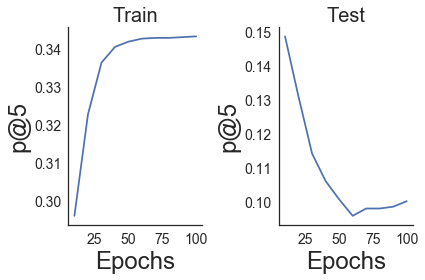

In [240]:
# Generate plot
import seaborn as sns
sns.set_style('white')

def plot_patk(iterarray, patk,
              title, k=5):
    plt.plot(iterarray, patk);
    plt.title(title, fontsize=20);
    plt.xlabel('Epochs', fontsize=24);
    plt.ylabel('p@{}'.format(k), fontsize=24);
    plt.xticks(fontsize=14);
    plt.yticks(fontsize=14);
    
# Plot train on left
ax = plt.subplot(1, 2, 1)
fig = ax.get_figure();
sns.despine(fig);
plot_patk(iterarray, train_patk,
         'Train', k=5)

# Plot test on right
ax = plt.subplot(1, 2, 2)
fig = ax.get_figure();
sns.despine(fig);
plot_patk(iterarray, test_patk,
         'Test', k=5)

plt.tight_layout();

Ouch...

In [241]:
# ICP features only
model = LightFM(loss='warp', random_state=2016)
model.fit_partial(train, user_features=icp_features, epochs=0) # just initialize

iterarray = range(10, 110, 10)
model, train_patk, test_patk = patk_learning_curve(
    model, train, test, iterarray, k=5,
    user_features=icp_features,
    **{'num_threads':1}
)

+------------+------------+------------+
|   Epoch    | train p@5  |  test p@5  |
+============+============+============+
|     10     |  0.25919   |  0.15067   |
+------------+------------+------------+
|     20     |  0.32134   |  0.14155   |
+------------+------------+------------+
|     30     |  0.33589   |  0.12493   |
+------------+------------+------------+
|     40     |  0.34061   |  0.10992   |
+------------+------------+------------+
|     50     |  0.34238   |  0.10831   |
+------------+------------+------------+
|     60     |  0.34277   |  0.10509   |
+------------+------------+------------+
|     70     |  0.34317   |  0.10188   |
+------------+------------+------------+
|     80     |  0.34317   |  0.10188   |
+------------+------------+------------+
|     90     |  0.34317   |  0.09973   |
+------------+------------+------------+
|    100     |  0.34317   |  0.09920   |
+------------+------------+------------+


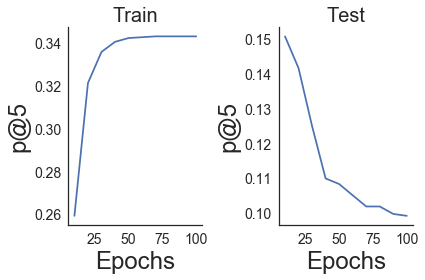

In [242]:
# Generate plot
import seaborn as sns
sns.set_style('white')

def plot_patk(iterarray, patk,
              title, k=5):
    plt.plot(iterarray, patk);
    plt.title(title, fontsize=20);
    plt.xlabel('Epochs', fontsize=24);
    plt.ylabel('p@{}'.format(k), fontsize=24);
    plt.xticks(fontsize=14);
    plt.yticks(fontsize=14);
    
# Plot train on left
ax = plt.subplot(1, 2, 1)
fig = ax.get_figure();
sns.despine(fig);
plot_patk(iterarray, train_patk,
         'Train', k=5)

# Plot test on right
ax = plt.subplot(1, 2, 2)
fig = ax.get_figure();
sns.despine(fig);
plot_patk(iterarray, test_patk,
         'Test', k=5)

plt.tight_layout();

In [243]:
# CDN features only
model = LightFM(loss='warp', random_state=2016)
model.fit_partial(train, item_features=cdn_features, epochs=0) # just initialize

iterarray = range(10, 110, 10)
model, train_patk, test_patk = patk_learning_curve(
    model, train, test, iterarray, k=5,
    item_features=cdn_features,
    **{'num_threads':1}
)

+------------+------------+------------+
|   Epoch    | train p@5  |  test p@5  |
+============+============+============+
|     10     |  0.31799   |  0.13619   |
+------------+------------+------------+
|     20     |  0.33392   |  0.12440   |
+------------+------------+------------+
|     30     |  0.33943   |  0.12011   |
+------------+------------+------------+
|     40     |  0.34218   |  0.11903   |
+------------+------------+------------+
|     50     |  0.34238   |  0.11796   |
+------------+------------+------------+
|     60     |  0.34277   |  0.11635   |
+------------+------------+------------+
|     70     |  0.34297   |  0.11528   |
+------------+------------+------------+
|     80     |  0.34317   |  0.11421   |
+------------+------------+------------+
|     90     |  0.34317   |  0.11475   |
+------------+------------+------------+
|    100     |  0.34317   |  0.11475   |
+------------+------------+------------+


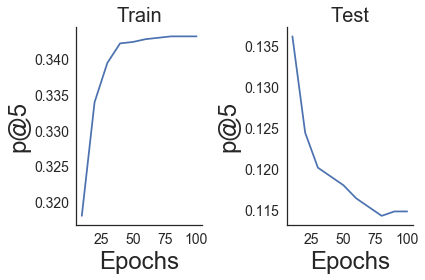

In [244]:
# Generate plot
import seaborn as sns
sns.set_style('white')

def plot_patk(iterarray, patk,
              title, k=5):
    plt.plot(iterarray, patk);
    plt.title(title, fontsize=20);
    plt.xlabel('Epochs', fontsize=24);
    plt.ylabel('p@{}'.format(k), fontsize=24);
    plt.xticks(fontsize=14);
    plt.yticks(fontsize=14);
    
# Plot train on left
ax = plt.subplot(1, 2, 1)
fig = ax.get_figure();
sns.despine(fig);
plot_patk(iterarray, train_patk,
         'Train', k=5)

# Plot test on right
ax = plt.subplot(1, 2, 2)
fig = ax.get_figure();
sns.despine(fig);
plot_patk(iterarray, test_patk,
         'Test', k=5)

plt.tight_layout();

In [245]:
# No features
model = LightFM(loss='warp', random_state=2016)
model.fit_partial(train, epochs=0) # just initialize

iterarray = range(10, 110, 10)
model, train_patk, test_patk = patk_learning_curve(
    model, train, test, iterarray, k=5,
    **{'num_threads':1}
)

+------------+------------+------------+
|   Epoch    | train p@5  |  test p@5  |
+============+============+============+
|     10     |  0.31681   |  0.13298   |
+------------+------------+------------+
|     20     |  0.33412   |  0.12225   |
+------------+------------+------------+
|     30     |  0.33963   |  0.12118   |
+------------+------------+------------+
|     40     |  0.34258   |  0.11957   |
+------------+------------+------------+
|     50     |  0.34297   |  0.11957   |
+------------+------------+------------+
|     60     |  0.34317   |  0.11903   |
+------------+------------+------------+
|     70     |  0.34317   |  0.11796   |
+------------+------------+------------+
|     80     |  0.34317   |  0.11743   |
+------------+------------+------------+
|     90     |  0.34317   |  0.11689   |
+------------+------------+------------+
|    100     |  0.34317   |  0.11689   |
+------------+------------+------------+


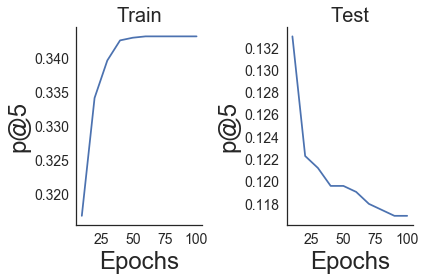

In [246]:
# Generate plot
import seaborn as sns
sns.set_style('white')

def plot_patk(iterarray, patk,
              title, k=5):
    plt.plot(iterarray, patk);
    plt.title(title, fontsize=20);
    plt.xlabel('Epochs', fontsize=24);
    plt.ylabel('p@{}'.format(k), fontsize=24);
    plt.xticks(fontsize=14);
    plt.yticks(fontsize=14);
    
# Plot train on left
ax = plt.subplot(1, 2, 1)
fig = ax.get_figure();
sns.despine(fig);
plot_patk(iterarray, train_patk,
         'Train', k=5)

# Plot test on right
ax = plt.subplot(1, 2, 2)
fig = ax.get_figure();
sns.despine(fig);
plot_patk(iterarray, test_patk,
         'Test', k=5)

plt.tight_layout();

## Hyperparameter Optimization
------
Earlier plots aren't looking too great... let's try something new.

Here's what we'll do: we'll use skopt's bayesian-based GP (gaussian process) optimization to optimize our hyperparameters on the All-Features model first, and see how that performs. This will also make sure we properly regularize our features as well so we don't end up overfitting the training data -- which, looking at the previous plots, seems like we were doing to a pretty large extent. We'll also be sure to plot ALL our epochs, not just starting from 10 and then moving in increments of 10.

(Apologies in advance for GitHub showing the entire verbose output logs without any built-in scrolling.)

In [350]:
# Hyperparameter optimization objective (Minimize -p@k)
def objective_all_features(params):
    # unpack
    epochs, learning_rate, no_components, item_alpha, user_alpha = params
    
    model = LightFM(loss='warp',
                   random_state=2016,
                   learning_rate=learning_rate,
                   no_components=no_components,
                   user_alpha=user_alpha,
                   item_alpha=item_alpha)
    model.fit(train, epochs=epochs,
             item_features=cdn_features,
             user_features=icp_features,
             verbose=False)
    
    patks = lightfm.evaluation.precision_at_k(model, test,
                                             item_features=cdn_features,
                                             user_features=icp_features,
                                             train_interactions=None,
                                             k=5)
    
    mapatk = np.mean(patks)
    out = -mapatk # want to minimize objective
    
    # "Weird shit going on"
    # Case 1: p@k really close to 1 (w/in 0.01)
    # Case 2: p@k > 1.0
    if np.abs(out + 1) < 0.01 or out < -1.0:
        return 0.0 # corresponds to high p@k
    else:
        return out

In [353]:
# Get ready to optimize hyperparameters
from skopt import gp_minimize

space = [(1, 260), # epochs
        (10**-3, 1.0, 'log-uniform'), # learning rate
        (20, 200), # no_components
        (10**-6, 10**-1, 'log-uniform'), # item_alpha
        (10**-6, 10**-1, 'log-uniform'), # user_alpha
        ]

In [354]:
# Run skopt on our p@k objective

opt_all_features = gp_minimize(objective_all_features,
                             space,
                             n_calls=200,
                             random_state=0,
                             verbose=True)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.6716
Function value obtained: -0.1013
Current minimum: -0.1013
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.5564
Function value obtained: -0.1142
Current minimum: -0.1142
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.6790
Function value obtained: -0.1239
Current minimum: -0.1239
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.1553
Function value obtained: -0.1566
Current minimum: -0.1566
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 1.0495
Function value obtained: -0.1196
Current minimum: -0.1566
Iteration No: 6 started. 

Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 2.5016
Function value obtained: -0.1566
Current minimum: -0.1576
Iteration No: 42 started. Searching for the next optimal point.
Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 2.3338
Function value obtained: -0.1566
Current minimum: -0.1576
Iteration No: 43 started. Searching for the next optimal point.
Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 0.9679
Function value obtained: -0.1528
Current minimum: -0.1576
Iteration No: 44 started. Searching for the next optimal point.
Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 2.8884
Function value obtained: -0.1566
Current minimum: -0.1576
Iteration No: 45 started. Searching for the next optimal point.
Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 0.9908
Function value obtained: -0.1491
Current minimum: -0.1576
Iteration No: 46 st

Iteration No: 81 ended. Search finished for the next optimal point.
Time taken: 2.3855
Function value obtained: -0.1105
Current minimum: -0.1576
Iteration No: 82 started. Searching for the next optimal point.
Iteration No: 82 ended. Search finished for the next optimal point.
Time taken: 5.5742
Function value obtained: -0.1566
Current minimum: -0.1576
Iteration No: 83 started. Searching for the next optimal point.
Iteration No: 83 ended. Search finished for the next optimal point.
Time taken: 6.7631
Function value obtained: -0.1544
Current minimum: -0.1576
Iteration No: 84 started. Searching for the next optimal point.
Iteration No: 84 ended. Search finished for the next optimal point.
Time taken: 2.2873
Function value obtained: -0.1566
Current minimum: -0.1576
Iteration No: 85 started. Searching for the next optimal point.
Iteration No: 85 ended. Search finished for the next optimal point.
Time taken: 3.0274
Function value obtained: -0.1501
Current minimum: -0.1576
Iteration No: 86 st

Iteration No: 121 ended. Search finished for the next optimal point.
Time taken: 4.2405
Function value obtained: -0.1544
Current minimum: -0.1576
Iteration No: 122 started. Searching for the next optimal point.
Iteration No: 122 ended. Search finished for the next optimal point.
Time taken: 2.6682
Function value obtained: -0.1292
Current minimum: -0.1576
Iteration No: 123 started. Searching for the next optimal point.
Iteration No: 123 ended. Search finished for the next optimal point.
Time taken: 6.7590
Function value obtained: -0.1544
Current minimum: -0.1576
Iteration No: 124 started. Searching for the next optimal point.
Iteration No: 124 ended. Search finished for the next optimal point.
Time taken: 2.0734
Function value obtained: -0.1566
Current minimum: -0.1576
Iteration No: 125 started. Searching for the next optimal point.
Iteration No: 125 ended. Search finished for the next optimal point.
Time taken: 7.4190
Function value obtained: -0.1566
Current minimum: -0.1576
Iteration 

Iteration No: 160 ended. Search finished for the next optimal point.
Time taken: 4.8886
Function value obtained: -0.1544
Current minimum: -0.1576
Iteration No: 161 started. Searching for the next optimal point.
Iteration No: 161 ended. Search finished for the next optimal point.
Time taken: 3.4833
Function value obtained: -0.1566
Current minimum: -0.1576
Iteration No: 162 started. Searching for the next optimal point.
Iteration No: 162 ended. Search finished for the next optimal point.
Time taken: 3.6513
Function value obtained: -0.1560
Current minimum: -0.1576
Iteration No: 163 started. Searching for the next optimal point.
Iteration No: 163 ended. Search finished for the next optimal point.
Time taken: 6.8714
Function value obtained: -0.1566
Current minimum: -0.1576
Iteration No: 164 started. Searching for the next optimal point.
Iteration No: 164 ended. Search finished for the next optimal point.
Time taken: 4.5456
Function value obtained: -0.1367
Current minimum: -0.1576
Iteration 

Iteration No: 199 ended. Search finished for the next optimal point.
Time taken: 4.8819
Function value obtained: -0.1566
Current minimum: -0.1576
Iteration No: 200 started. Searching for the next optimal point.
Iteration No: 200 ended. Search finished for the next optimal point.
Time taken: 1.3582
Function value obtained: -0.1566
Current minimum: -0.1576


In [710]:
# Store optimal hyperparameters
opt_epochs_all, opt_lr_all, opt_no_components_all, opt_item_alpha_all, opt_user_alpha_all = opt_all_features.x
print opt_all_features.x
print opt_all_features.fun

[105, 0.001, 200, 9.9999999999999995e-07, 9.9999999999999995e-07]
-0.157641


In [715]:
# Re-train optimal all-features model
opt_model_all = LightFM(loss='warp',
                   random_state=2016,
                   learning_rate=opt_lr_all,
                   no_components=opt_no_components_all,
                   user_alpha=opt_user_alpha_all,
                   item_alpha=opt_item_alpha_all)
opt_model_all.fit(train, user_features=icp_features, item_features=cdn_features, epochs=opt_epochs_all)

In [716]:
# Evaluate optimal CDN-features-only model
all_opt_patk = lightfm.evaluation.precision_at_k(opt_model_all, test,
                                             user_features=icp_features,
                                             item_features=cdn_features,
                                             train_interactions=None,
                                             k=5).mean()
all_opt_auc = lightfm.evaluation.auc_score(opt_model_all, test,
                                             user_features=icp_features,
                                             item_features=cdn_features,
                                             train_interactions=None
                                             ).mean()
print "All Features Optimal p@5: " + str(all_opt_patk)
print "All Features Optimal AUC: " + str(all_opt_auc)

All Features Optimal p@5: 0.157641
All Features Optimal AUC: 0.891078


Final test p@5: 0.157641
Final test AUC: 0.891078


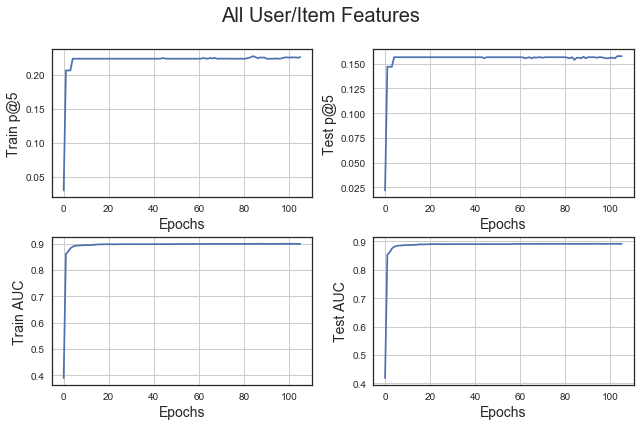

In [564]:
# Try tracking p@5 at each epoch
train_patks = []
test_patks = []
train_aucs = []
test_aucs = []

K = 5

# Initiate model
opt_model_all = LightFM(loss='warp',
                   random_state=2016,
                   learning_rate=opt_lr_all,
                   no_components=opt_no_components_all,
                   user_alpha=opt_user_alpha_all,
                   item_alpha=opt_item_alpha_all)

# Pre-training evaluation
opt_model_all.fit_partial(train, user_features=icp_features, item_features=cdn_features, epochs=0)
train_patk = lightfm.evaluation.precision_at_k(opt_model_all, train,
                                         item_features=cdn_features,
                                         user_features=icp_features,
                                         train_interactions=None,
                                         k=K).mean()
test_patk = lightfm.evaluation.precision_at_k(opt_model_all, test,
                                         item_features=cdn_features,
                                         user_features=icp_features,
                                         k=K).mean()
train_auc = lightfm.evaluation.auc_score(opt_model_all, train,
                                         item_features=cdn_features,
                                         user_features=icp_features
                                         ).mean()
test_auc = lightfm.evaluation.auc_score(opt_model_all, test,
                                         item_features=cdn_features,
                                         user_features=icp_features
                                         ).mean()

train_patks.append(train_patk)
test_patks.append(test_patk)
train_aucs.append(train_auc)
test_aucs.append(test_auc)

# Loop over optimal num. epochs
for i in range(opt_epochs_all):
    # run through 1 epoch
    opt_model_all.fit_partial(train, user_features=icp_features, item_features=cdn_features)
    
    # Evaluate
    train_patk = lightfm.evaluation.precision_at_k(opt_model_all, train,
                                             item_features=cdn_features,
                                             user_features=icp_features,
                                             train_interactions=None,
                                             k=K).mean()
    test_patk = lightfm.evaluation.precision_at_k(opt_model_all, test,
                                             item_features=cdn_features,
                                             user_features=icp_features,
                                             k=K).mean()
    train_auc = lightfm.evaluation.auc_score(opt_model_all, train,
                                             item_features=cdn_features,
                                             user_features=icp_features
                                             ).mean()
    test_auc = lightfm.evaluation.auc_score(opt_model_all, test,
                                             item_features=cdn_features,
                                             user_features=icp_features
                                             ).mean()
    
    train_patks.append(train_patk)
    test_patks.append(test_patk)
    train_aucs.append(train_auc)
    test_aucs.append(test_auc)

print "Final test p@{}: ".format(K) + str(test_patks[-1])
print "Final test AUC: " + str(test_aucs[-1])
    
    
### Plot the result ###

plt.suptitle('All User/Item Features', fontsize=20)

# Train plot
plt.subplot(2, 2, 1)
plt.plot(train_patks)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Train p@{}'.format(K), fontsize=14)
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(test_patks)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Test p@{}'.format(K), fontsize=14)
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(train_aucs)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Train AUC', fontsize=14)
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(test_aucs)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Test AUC', fontsize=14)
plt.grid(True)

plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()

Looks like we were missing out on the initial jump! Thank god. The earlier plots were only showing the post-plateau changes.

### Quick Detour: Test Data Analysis
-------
Not sure why I decided to do this here honestly. This info (particularly the info on the number of cold-start users) will come in handy later though, we we evaluate our model's performance in warm-start vs. cold-start scenarios.

In [362]:
print train[train.getnnz(1) > 0].shape
print train.shape

(1017, 39)
(1151, 39)


In [363]:
print test[test.getnnz(1) > 0].shape
print test.shape
# Testing on 373 users

(373, 39)
(1151, 39)


In [364]:
1151-1017
# Looks like we are in cold-start for 134 users

134

In [365]:
set(train.data)

{1.0}

## Other Feature Combinations
------
See what inputted user/item features allows our RecSys to perform the best after being optimized. Select the best model to continue evaluating moving forward.

#### Models Tested:
1. All Features -  Hybrid (See Above)
2. No Features - Pure Collaborative-Filtering
3. User (ICP) Features Only - Hybrid
4. Item (CDN) Features Only - Hybrid

### No Features (Pure Collaborative-Filtering)

In [394]:
# Hyperparameter optimization objective (Minimize -p@k)
def objective_no_features(params):
    # unpack
    epochs, learning_rate, no_components, item_alpha, user_alpha = params
    
    model = LightFM(loss='warp',
                   random_state=2016,
                   learning_rate=learning_rate,
                   no_components=no_components,
                   user_alpha=user_alpha,
                   item_alpha=item_alpha)
    model.fit(train, epochs=epochs,
             verbose=False)
    
    patks = lightfm.evaluation.precision_at_k(model, test,
                                             train_interactions=None,
                                             k=5)
    
    mapatk = np.mean(patks)
    out = -mapatk # want to minimize objective
    
    # "Weird shit going on"
    # Case 1: p@k really close to 1 (w/in 0.01)
    # Case 2: p@k > 1.0
    if np.abs(out + 1) < 0.01 or out < -1.0:
        return 0.0 # corresponds to high p@k
    else:
        return out

In [395]:
# Run skopt on our p@k objective

opt_no_features = gp_minimize(objective_no_features,
                             space,
                             n_calls=200,
                             random_state=0,
                             verbose=True)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.8720
Function value obtained: -0.1421
Current minimum: -0.1421
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.3962
Function value obtained: -0.1088
Current minimum: -0.1421
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.4207
Function value obtained: -0.1008
Current minimum: -0.1421
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.0654
Function value obtained: -0.1566
Current minimum: -0.1566
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 1.5543
Function value obtained: -0.1180
Current minimum: -0.1566
Iteration No: 6 started. 

Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 3.8868
Function value obtained: -0.1550
Current minimum: -0.1566
Iteration No: 42 started. Searching for the next optimal point.
Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 1.1537
Function value obtained: -0.1555
Current minimum: -0.1566
Iteration No: 43 started. Searching for the next optimal point.
Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 1.1466
Function value obtained: -0.1180
Current minimum: -0.1566
Iteration No: 44 started. Searching for the next optimal point.
Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 1.3540
Function value obtained: -0.1362
Current minimum: -0.1566
Iteration No: 45 started. Searching for the next optimal point.
Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 1.0205
Function value obtained: -0.1566
Current minimum: -0.1566
Iteration No: 46 st

Iteration No: 81 ended. Search finished for the next optimal point.
Time taken: 1.4784
Function value obtained: -0.1512
Current minimum: -0.1571
Iteration No: 82 started. Searching for the next optimal point.
Iteration No: 82 ended. Search finished for the next optimal point.
Time taken: 2.4421
Function value obtained: -0.1566
Current minimum: -0.1571
Iteration No: 83 started. Searching for the next optimal point.
Iteration No: 83 ended. Search finished for the next optimal point.
Time taken: 4.7941
Function value obtained: -0.1566
Current minimum: -0.1571
Iteration No: 84 started. Searching for the next optimal point.
Iteration No: 84 ended. Search finished for the next optimal point.
Time taken: 3.3327
Function value obtained: -0.1566
Current minimum: -0.1571
Iteration No: 85 started. Searching for the next optimal point.
Iteration No: 85 ended. Search finished for the next optimal point.
Time taken: 4.3244
Function value obtained: -0.1566
Current minimum: -0.1571
Iteration No: 86 st

Iteration No: 121 ended. Search finished for the next optimal point.
Time taken: 3.2882
Function value obtained: -0.1566
Current minimum: -0.1571
Iteration No: 122 started. Searching for the next optimal point.
Iteration No: 122 ended. Search finished for the next optimal point.
Time taken: 3.2913
Function value obtained: -0.1566
Current minimum: -0.1571
Iteration No: 123 started. Searching for the next optimal point.
Iteration No: 123 ended. Search finished for the next optimal point.
Time taken: 3.2201
Function value obtained: -0.1566
Current minimum: -0.1571
Iteration No: 124 started. Searching for the next optimal point.
Iteration No: 124 ended. Search finished for the next optimal point.
Time taken: 2.6847
Function value obtained: -0.1566
Current minimum: -0.1571
Iteration No: 125 started. Searching for the next optimal point.
Iteration No: 125 ended. Search finished for the next optimal point.
Time taken: 2.9872
Function value obtained: -0.1485
Current minimum: -0.1571
Iteration 

Iteration No: 160 ended. Search finished for the next optimal point.
Time taken: 5.9122
Function value obtained: -0.1566
Current minimum: -0.1571
Iteration No: 161 started. Searching for the next optimal point.
Iteration No: 161 ended. Search finished for the next optimal point.
Time taken: 4.5549
Function value obtained: -0.1550
Current minimum: -0.1571
Iteration No: 162 started. Searching for the next optimal point.
Iteration No: 162 ended. Search finished for the next optimal point.
Time taken: 4.8512
Function value obtained: -0.1566
Current minimum: -0.1571
Iteration No: 163 started. Searching for the next optimal point.
Iteration No: 163 ended. Search finished for the next optimal point.
Time taken: 4.6592
Function value obtained: -0.1566
Current minimum: -0.1571
Iteration No: 164 started. Searching for the next optimal point.
Iteration No: 164 ended. Search finished for the next optimal point.
Time taken: 4.3483
Function value obtained: -0.1351
Current minimum: -0.1571
Iteration 

Iteration No: 199 ended. Search finished for the next optimal point.
Time taken: 7.4711
Function value obtained: -0.1566
Current minimum: -0.1571
Iteration No: 200 started. Searching for the next optimal point.
Iteration No: 200 ended. Search finished for the next optimal point.
Time taken: 4.8450
Function value obtained: -0.1566
Current minimum: -0.1571


In [396]:
print opt_no_features.x
print opt_no_features.fun

[24, 0.0043187178281356943, 71, 0.10000000000000001, 9.9999999999999995e-07]
-0.157105


In [693]:
# Re-train optimal no-features model
opt_epochs_none, opt_lr_none, opt_no_components_none, opt_item_alpha_none, opt_user_alpha_none = opt_no_features.x
opt_model_none = LightFM(loss='warp',
                       random_state=2016,
                       learning_rate=opt_lr_none,
                       no_components=opt_no_components_none,
                       user_alpha=opt_user_alpha_none,
                       item_alpha=opt_item_alpha_none)
opt_model_none.fit(train, epochs=opt_epochs_none)

In [694]:
# Evaluate optimal CDN-features-only model
none_opt_patk = lightfm.evaluation.precision_at_k(opt_model_none, test,
                                             train_interactions=None,
                                             k=5).mean()
none_opt_auc = lightfm.evaluation.auc_score(opt_model_none, test,
                                             train_interactions=None
                                             ).mean()
print "No Features Optimal p@5: " + str(none_opt_patk)
print "No Features Optimal AUC: " + str(none_opt_auc)

No Features Optimal p@5: 0.157105
No Features Optimal AUC: 0.887442


### ICP Features Only (Hybrid)

In [415]:
# Hyperparameter optimization objective (Minimize -p@k)
def objective_icp_features(params):
    # unpack
    epochs, learning_rate, no_components, item_alpha, user_alpha = params
    
    model = LightFM(loss='warp',
                   random_state=2016,
                   learning_rate=learning_rate,
                   no_components=no_components,
                   user_alpha=user_alpha,
                   item_alpha=item_alpha)
    model.fit(train, epochs=epochs,
             user_features=icp_features,
             verbose=False)
    
    patks = lightfm.evaluation.precision_at_k(model, test,
                                             user_features=icp_features,
                                             train_interactions=None,
                                             k=5)
    
    mapatk = np.mean(patks)
    out = -mapatk # want to minimize objective
    
    # "Weird shit going on"
    # Case 1: p@k really close to 1 (w/in 0.01)
    # Case 2: p@k > 1.0
    if np.abs(out + 1) < 0.01 or out < -1.0:
        return 0.0 # corresponds to high p@k
    else:
        return out

In [416]:
# Run skopt on our p@k objective

opt_icp_features = gp_minimize(objective_icp_features,
                             space,
                             n_calls=200,
                             random_state=0,
                             verbose=True)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 1.3182
Function value obtained: -0.1201
Current minimum: -0.1201
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.5407
Function value obtained: -0.1147
Current minimum: -0.1201
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.7693
Function value obtained: -0.1233
Current minimum: -0.1233
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.1979
Function value obtained: -0.1566
Current minimum: -0.1566
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.7758
Function value obtained: -0.1223
Current minimum: -0.1566
Iteration No: 6 started. 

Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 2.5205
Function value obtained: -0.1094
Current minimum: -0.1566
Iteration No: 42 started. Searching for the next optimal point.
Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 0.9382
Function value obtained: -0.1566
Current minimum: -0.1566
Iteration No: 43 started. Searching for the next optimal point.
Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 3.6769
Function value obtained: -0.1566
Current minimum: -0.1566
Iteration No: 44 started. Searching for the next optimal point.
Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 2.2048
Function value obtained: -0.1566
Current minimum: -0.1566
Iteration No: 45 started. Searching for the next optimal point.
Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 1.1799
Function value obtained: -0.1566
Current minimum: -0.1566
Iteration No: 46 st

Iteration No: 81 ended. Search finished for the next optimal point.
Time taken: 2.2210
Function value obtained: -0.1566
Current minimum: -0.1566
Iteration No: 82 started. Searching for the next optimal point.
Iteration No: 82 ended. Search finished for the next optimal point.
Time taken: 2.7532
Function value obtained: -0.1566
Current minimum: -0.1566
Iteration No: 83 started. Searching for the next optimal point.
Iteration No: 83 ended. Search finished for the next optimal point.
Time taken: 3.6415
Function value obtained: -0.1566
Current minimum: -0.1566
Iteration No: 84 started. Searching for the next optimal point.
Iteration No: 84 ended. Search finished for the next optimal point.
Time taken: 2.6053
Function value obtained: -0.1566
Current minimum: -0.1566
Iteration No: 85 started. Searching for the next optimal point.
Iteration No: 85 ended. Search finished for the next optimal point.
Time taken: 2.0857
Function value obtained: -0.1566
Current minimum: -0.1566
Iteration No: 86 st

Iteration No: 121 ended. Search finished for the next optimal point.
Time taken: 5.1826
Function value obtained: -0.1566
Current minimum: -0.1566
Iteration No: 122 started. Searching for the next optimal point.
Iteration No: 122 ended. Search finished for the next optimal point.
Time taken: 3.0715
Function value obtained: -0.1566
Current minimum: -0.1566
Iteration No: 123 started. Searching for the next optimal point.
Iteration No: 123 ended. Search finished for the next optimal point.
Time taken: 5.5544
Function value obtained: -0.1566
Current minimum: -0.1566
Iteration No: 124 started. Searching for the next optimal point.
Iteration No: 124 ended. Search finished for the next optimal point.
Time taken: 2.6939
Function value obtained: -0.1544
Current minimum: -0.1566
Iteration No: 125 started. Searching for the next optimal point.
Iteration No: 125 ended. Search finished for the next optimal point.
Time taken: 3.0157
Function value obtained: -0.1566
Current minimum: -0.1566
Iteration 

Iteration No: 160 ended. Search finished for the next optimal point.
Time taken: 4.1755
Function value obtained: -0.1566
Current minimum: -0.1576
Iteration No: 161 started. Searching for the next optimal point.
Iteration No: 161 ended. Search finished for the next optimal point.
Time taken: 3.7914
Function value obtained: -0.1566
Current minimum: -0.1576
Iteration No: 162 started. Searching for the next optimal point.
Iteration No: 162 ended. Search finished for the next optimal point.
Time taken: 5.7375
Function value obtained: -0.1555
Current minimum: -0.1576
Iteration No: 163 started. Searching for the next optimal point.
Iteration No: 163 ended. Search finished for the next optimal point.
Time taken: 4.3965
Function value obtained: -0.1566
Current minimum: -0.1576
Iteration No: 164 started. Searching for the next optimal point.
Iteration No: 164 ended. Search finished for the next optimal point.
Time taken: 4.9490
Function value obtained: -0.1566
Current minimum: -0.1576
Iteration 

Iteration No: 199 ended. Search finished for the next optimal point.
Time taken: 4.5710
Function value obtained: -0.1534
Current minimum: -0.1576
Iteration No: 200 started. Searching for the next optimal point.
Iteration No: 200 ended. Search finished for the next optimal point.
Time taken: 2.1455
Function value obtained: -0.1560
Current minimum: -0.1576


In [417]:
print opt_icp_features.x
print opt_icp_features.fun

[32, 0.017970149933404515, 20, 0.10000000000000001, 0.00071476262926802579]
-0.157641


In [ ]:
# opt_epochs_icp, opt_lr_icp, opt_no_components_icp, opt_item_alpha_icp, opt_user_alpha_icp = opt_icp_features.x

# I got these optimal hyperparamteres on an earlier skopt call 
# but for some reason it couldn't find them the next couple calls around. Thankfully was able to copy/paste.
opt_epochs_icp, opt_lr_icp, opt_no_components_icp, opt_item_alpha_icp, opt_user_alpha_icp = \
[51, 0.0040253901900726063, 158, 9.9999999999999995e-07, 9.9999999999999995e-07]

In [699]:
# Re-train optimal ICP-features-only model
opt_model_icp = LightFM(loss='warp',
                       random_state=2016,
                       learning_rate=opt_lr_icp,
                       no_components=opt_no_components_icp,
                       user_alpha=opt_user_alpha_icp,
                       item_alpha=opt_item_alpha_icp)
opt_model_icp.fit(train, epochs=opt_epochs_icp, user_features=icp_features)

In [700]:
# Evaluate optimal ICP-features-only model
icp_opt_patk = lightfm.evaluation.precision_at_k(opt_model_icp, test,
                                             user_features=icp_features,
                                             train_interactions=None,
                                             k=5).mean()
icp_opt_auc = lightfm.evaluation.auc_score(opt_model_icp, test,
                                             user_features=icp_features,
                                             train_interactions=None
                                             ).mean()
print "ICP Features Only Optimal p@5: " + str(icp_opt_patk)
print "ICP Features Only Optimal AUC: " + str(icp_opt_auc)

ICP Features Only Optimal p@5: 0.158713
ICP Features Only Optimal AUC: 0.891215


### CDN Features Only (Hybrid)

In [385]:
# Hyperparameter optimization objective (Minimize -p@k)
def objective_cdn_features(params):
    # unpack
    epochs, learning_rate, no_components, item_alpha, user_alpha = params
    
    model = LightFM(loss='warp',
                   random_state=2016,
                   learning_rate=learning_rate,
                   no_components=no_components,
                   user_alpha=user_alpha,
                   item_alpha=item_alpha)
    model.fit(train, epochs=epochs,
             item_features=cdn_features,
             verbose=False)
    
    patks = lightfm.evaluation.precision_at_k(model, test,
                                             item_features=cdn_features,
                                             train_interactions=None,
                                             k=5)
    
    mapatk = np.mean(patks)
    out = -mapatk # want to minimize objective
    
    # "Weird shit going on"
    # Case 1: p@k really close to 1 (w/in 0.01)
    # Case 2: p@k > 1.0
    if np.abs(out + 1) < 0.01 or out < -1.0:
        return 0.0 # corresponds to high p@k
    else:
        return out

In [386]:
# Run skopt on our p@k objective

opt_cdn_features = gp_minimize(objective_cdn_features,
                             space,
                             n_calls=200,
                             random_state=0,
                             verbose=True)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.8353
Function value obtained: -0.0949
Current minimum: -0.0949
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.4476
Function value obtained: -0.1024
Current minimum: -0.1024
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.6058
Function value obtained: -0.1137
Current minimum: -0.1137
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.1161
Function value obtained: -0.1469
Current minimum: -0.1469
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 1.6802
Function value obtained: -0.1201
Current minimum: -0.1469
Iteration No: 6 started. 

Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 0.9661
Function value obtained: -0.1469
Current minimum: -0.1501
Iteration No: 42 started. Searching for the next optimal point.
Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 2.0068
Function value obtained: -0.0820
Current minimum: -0.1501
Iteration No: 43 started. Searching for the next optimal point.
Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 0.8972
Function value obtained: -0.1528
Current minimum: -0.1528
Iteration No: 44 started. Searching for the next optimal point.
Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 3.2237
Function value obtained: -0.1453
Current minimum: -0.1528
Iteration No: 45 started. Searching for the next optimal point.
Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 0.9439
Function value obtained: -0.1389
Current minimum: -0.1528
Iteration No: 46 st

Iteration No: 81 ended. Search finished for the next optimal point.
Time taken: 2.4948
Function value obtained: -0.1469
Current minimum: -0.1571
Iteration No: 82 started. Searching for the next optimal point.
Iteration No: 82 ended. Search finished for the next optimal point.
Time taken: 5.7158
Function value obtained: -0.1539
Current minimum: -0.1571
Iteration No: 83 started. Searching for the next optimal point.
Iteration No: 83 ended. Search finished for the next optimal point.
Time taken: 3.1356
Function value obtained: -0.1517
Current minimum: -0.1571
Iteration No: 84 started. Searching for the next optimal point.
Iteration No: 84 ended. Search finished for the next optimal point.
Time taken: 1.6977
Function value obtained: -0.1469
Current minimum: -0.1571
Iteration No: 85 started. Searching for the next optimal point.
Iteration No: 85 ended. Search finished for the next optimal point.
Time taken: 2.0245
Function value obtained: -0.1517
Current minimum: -0.1571
Iteration No: 86 st

Iteration No: 121 ended. Search finished for the next optimal point.
Time taken: 3.1297
Function value obtained: -0.1469
Current minimum: -0.1571
Iteration No: 122 started. Searching for the next optimal point.
Iteration No: 122 ended. Search finished for the next optimal point.
Time taken: 5.0768
Function value obtained: -0.1469
Current minimum: -0.1571
Iteration No: 123 started. Searching for the next optimal point.
Iteration No: 123 ended. Search finished for the next optimal point.
Time taken: 2.3135
Function value obtained: -0.1469
Current minimum: -0.1571
Iteration No: 124 started. Searching for the next optimal point.
Iteration No: 124 ended. Search finished for the next optimal point.
Time taken: 3.7779
Function value obtained: -0.1491
Current minimum: -0.1571
Iteration No: 125 started. Searching for the next optimal point.
Iteration No: 125 ended. Search finished for the next optimal point.
Time taken: 4.8825
Function value obtained: -0.1480
Current minimum: -0.1571
Iteration 

Iteration No: 160 ended. Search finished for the next optimal point.
Time taken: 8.3962
Function value obtained: -0.1448
Current minimum: -0.1571
Iteration No: 161 started. Searching for the next optimal point.
Iteration No: 161 ended. Search finished for the next optimal point.
Time taken: 3.4982
Function value obtained: -0.1346
Current minimum: -0.1571
Iteration No: 162 started. Searching for the next optimal point.
Iteration No: 162 ended. Search finished for the next optimal point.
Time taken: 3.5301
Function value obtained: -0.1528
Current minimum: -0.1571
Iteration No: 163 started. Searching for the next optimal point.
Iteration No: 163 ended. Search finished for the next optimal point.
Time taken: 3.9152
Function value obtained: -0.1469
Current minimum: -0.1571
Iteration No: 164 started. Searching for the next optimal point.
Iteration No: 164 ended. Search finished for the next optimal point.
Time taken: 4.5194
Function value obtained: -0.1469
Current minimum: -0.1571
Iteration 

Iteration No: 199 ended. Search finished for the next optimal point.
Time taken: 5.5380
Function value obtained: -0.1485
Current minimum: -0.1571
Iteration No: 200 started. Searching for the next optimal point.
Iteration No: 200 ended. Search finished for the next optimal point.
Time taken: 0.1689
Function value obtained: -0.1544
Current minimum: -0.1571


In [387]:
print opt_cdn_features.x
print opt_cdn_features.fun

[80, 0.010854932900583737, 66, 9.9999999999999995e-07, 0.10000000000000001]
-0.157105


In [701]:
# Re-train optimal CDN-features-only model
opt_epochs_cdn, opt_lr_cdn, opt_no_components_cdn, opt_item_alpha_cdn, opt_user_alpha_cdn = opt_cdn_features.x
opt_model_cdn = LightFM(loss='warp',
                       random_state=2016,
                       learning_rate=opt_lr_cdn,
                       no_components=opt_no_components_cdn,
                       user_alpha=opt_user_alpha_cdn,
                       item_alpha=opt_item_alpha_cdn)
opt_model_cdn.fit(train, epochs=opt_epochs_cdn, item_features=cdn_features)

In [702]:
# Evaluate optimal CDN-features-only model
cdn_opt_patk = lightfm.evaluation.precision_at_k(opt_model_cdn, test,
                                             item_features=cdn_features,
                                             train_interactions=None,
                                             k=5).mean()
cdn_opt_auc = lightfm.evaluation.auc_score(opt_model_cdn, test,
                                             item_features=cdn_features,
                                             train_interactions=None
                                             ).mean()
print "CDN Features Only Optimal p@5: " + str(cdn_opt_patk)
print "CDN Features Only Optimal AUC: " + str(cdn_opt_auc)

CDN Features Only Optimal p@5: 0.157105
CDN Features Only Optimal AUC: 0.889017


The CDN-features-only p@k was exactly the same as with no features at all! Looks like our current CDN features aren't really helping. Perhaps they're simply giving the model more noise than anything else. If I had more time, I'd want to look into how to use feature-engineering to pick some better features for the CDNs. For now, we'll just toss them.

**And the winner is: ICP features only!** Looks like the ICP features are indeed valuable for the model. In fact, removing the CDN features from the All-Features model and just leaving the ICP features improved our performance in both p@k and AUC. Next step is to evaluate the best-performing ICP Features Only model more in-depth.

### ICP Features Only: Learning Curves, Evaluation Continued

In [603]:
# Use optimal hyperparameters
opt_epochs_icp, opt_lr_icp, opt_no_components_icp, opt_item_alpha_icp, opt_user_alpha_icp = \
[51, 0.0040253901900726063, 158, 9.9999999999999995e-07, 9.9999999999999995e-07]

Final test p@5: 0.158713
Final test AUC: 0.891215


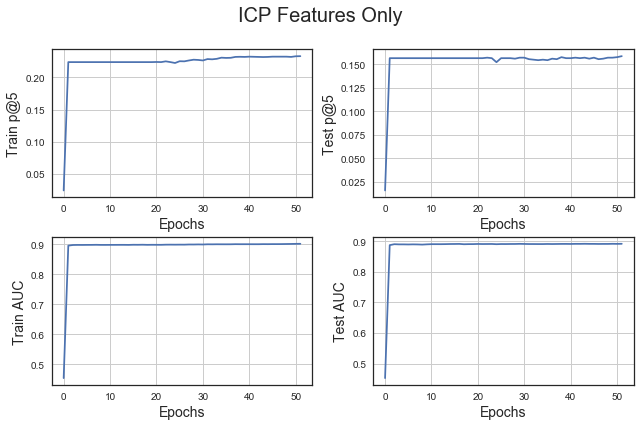

In [456]:
# Try tracking p@5 at each epoch
train_patks = []
test_patks = []
train_aucs = []
test_aucs = []

K = 5

# Initiate model
opt_model_icp = LightFM(loss='warp',
                   random_state=2016,
                   learning_rate=opt_lr_icp,
                   no_components=opt_no_components_icp,
                   user_alpha=opt_user_alpha_icp,
                   item_alpha=opt_item_alpha_icp)

# Pre-training evaluation
opt_model_icp.fit_partial(train, user_features=icp_features, epochs=0)
train_patk = lightfm.evaluation.precision_at_k(opt_model_icp, train,
                                         user_features=icp_features,
                                         train_interactions=None,
                                         k=K).mean()
test_patk = lightfm.evaluation.precision_at_k(opt_model_icp, test,
                                         user_features=icp_features,
                                         k=K).mean()
train_auc = lightfm.evaluation.auc_score(opt_model_icp, train,
                                         user_features=icp_features
                                         ).mean()
test_auc = lightfm.evaluation.auc_score(opt_model_icp, test,
                                         user_features=icp_features
                                         ).mean()

train_patks.append(train_patk)
test_patks.append(test_patk)
train_aucs.append(train_auc)
test_aucs.append(test_auc)

# Loop over optimal num. epochs
for i in range(opt_epochs_icp):
    # run through 1 epoch
    opt_model_icp.fit_partial(train, user_features=icp_features)
    
    # Evaluate
    train_patk = lightfm.evaluation.precision_at_k(opt_model_icp, train,
                                             user_features=icp_features,
                                             train_interactions=None,
                                             k=K).mean()
    test_patk = lightfm.evaluation.precision_at_k(opt_model_icp, test,
                                             user_features=icp_features,
                                             k=K).mean()
    train_auc = lightfm.evaluation.auc_score(opt_model_icp, train,
                                             user_features=icp_features
                                             ).mean()
    test_auc = lightfm.evaluation.auc_score(opt_model_icp, test,
                                             user_features=icp_features
                                             ).mean()
    
    train_patks.append(train_patk)
    test_patks.append(test_patk)
    train_aucs.append(train_auc)
    test_aucs.append(test_auc)
    
print "Final test p@{}: ".format(K) + str(test_patks[-1])
print "Final test AUC: " + str(test_aucs[-1])


### Plot the result ###

plt.suptitle('ICP Features Only', fontsize=20)

# Train plot
plt.subplot(2, 2, 1)
plt.plot(train_patks)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Train p@{}'.format(K), fontsize=14)
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(test_patks)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Test p@{}'.format(K), fontsize=14)
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(train_aucs)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Train AUC', fontsize=14)
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(test_aucs)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Test AUC', fontsize=14)
plt.grid(True)

plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()

Looks pretty good to me :)

## Cold Start vs. Warm Start
------
Now that we know that ICP-feature-only seems to be our best-performing model, let's see how well it does in warm-start (user has some interactions in training set) vs. cold-start scenarios (no data in training set -- new user). We'll pick apart the test data to see which test interactions are cold-start and which are warm-start, and then evaluate our model performance in each case.

The ultimate goal is that a new company can input its ICP features, and then get a reasonable suggestion for which CDN to use.

#### Part 1: Warm-Cold Split

In [459]:
train[train.getnnz(1) == 0].shape
# 134 cold start users in test set

(134, 39)

In [462]:
test[test.getnnz(1) > 0].shape
# 373 total users in test set

(373, 39)

In [464]:
373 - 134
# 239 warm-start users in test set

239

In [486]:
cold_start_bools = list(train.getnnz(1) == 0)
cold_start_uidxs = [uidx for uidx, cold in enumerate(cold_start_bools) if cold == True]
len(cold_start_uidxs)

134

In [469]:
in_test_bools = test.getnnz(1) > 0
test_uidxs = [uidx for uidx, in_test in enumerate(in_test_bools) if in_test == True]

In [472]:
# Quick sanity check
len(set(test_uidxs) & set(cold_start_uidxs))

134

In [473]:
test_uidxs = set(test_uidxs)
cold_start_uidxs = set(cold_start_uidxs)
warm_start_uidxs = test_uidxs - cold_start_uidxs # in test set, but not in cold start set
len(warm_start_uidxs)

239

In [476]:
warm_start_bools = [in_test and not cold_start \
                    for (in_test, cold_start) in zip(in_test_bools, cold_start_bools)]

In [488]:
# Another sanity check
print warm_start_bools.count(True)
print cold_start_bools.count(True)
print warm_start_bools.count(True) + cold_start_bools.count(True)

239
134
373


In [554]:
# to numpy array
test_array = test.toarray()
print test_array.shape

(1151, 39)


In [555]:
# Initialize empty
test_warm = np.zeros(test_array.shape)
test_cold = np.zeros(test_array.shape)

In [559]:
# Add warm/cold entries to warm/cold-start test arrays
for uidx in warm_start_uidxs:
    test_warm[uidx] = test_array[uidx]
    
for uidx in cold_start_uidxs:
    test_cold[uidx] = test_array[uidx]
    
assert (np.multiply(test_warm, test_cold).all() == 0) # test_warm, test_cold are disjoint
assert (np.array_equal(test_warm + test_cold, test_array) == True) # test_warm, test_cold comprise test set

In [561]:
test_warm = csr_matrix(test_warm)
test_cold = csr_matrix(test_cold)

In [676]:
# Save warm-cold matrices
with open('20170705-warm-cold.pkl', 'w') as output:
    pickle.dump((test_warm, test_cold), output, -1)

#### Part 2: Warm-Cold Evaluation

In [565]:
# Post-training, Test warm vs. cold p@k
print "Warm users: " + str(lightfm.evaluation.precision_at_k(opt_model_icp, test_warm,
                                             user_features=icp_features,
                                             k=K).mean())
print "Cold users: " + str(lightfm.evaluation.precision_at_k(opt_model_icp, test_cold,
                                             user_features=icp_features,
                                             k=K).mean())

Warm users: 0.160669
Cold users: 0.155224


In [598]:
print opt_epochs_icp

51


Final warm-start test p@5: 0.160669
Final cold-start test p@5: 0.155224
Final warm-start test AUC: 0.883059
Final cold-start test AUC: 0.905761


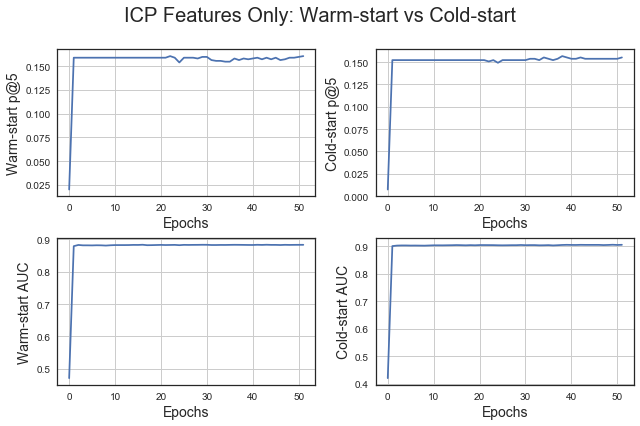

In [604]:
# Try tracking p@5 at each epoch
warm_patks = []
cold_patks = []
warm_aucs = []
cold_aucs = []

K = 5

# Initiate model
opt_model_icp = LightFM(loss='warp',
                   random_state=2016,
                   learning_rate=opt_lr_icp,
                   no_components=opt_no_components_icp,
                   user_alpha=opt_user_alpha_icp,
                   item_alpha=opt_item_alpha_icp)

# Pre-training evaluation
opt_model_icp.fit_partial(train, user_features=icp_features, epochs=0)
warm_patk = lightfm.evaluation.precision_at_k(opt_model_icp, test_warm,
                                         user_features=icp_features,
                                         k=K).mean()
cold_patk = lightfm.evaluation.precision_at_k(opt_model_icp, test_cold,
                                         user_features=icp_features,
                                         k=K).mean()
warm_auc = lightfm.evaluation.auc_score(opt_model_icp, test_warm,
                                         user_features=icp_features
                                         ).mean()
cold_auc = lightfm.evaluation.auc_score(opt_model_icp, test_cold,
                                         user_features=icp_features
                                         ).mean()

warm_patks.append(warm_patk)
cold_patks.append(cold_patk)
warm_aucs.append(warm_auc)
cold_aucs.append(cold_auc)

# Loop over optimal num. epochs
for i in range(opt_epochs_icp):
    # run through 1 epoch
    opt_model_icp.fit_partial(train, user_features=icp_features)
    
    # Evaluate
    warm_patk = lightfm.evaluation.precision_at_k(opt_model_icp, test_warm,
                                             user_features=icp_features,
                                             k=K).mean()
    cold_patk = lightfm.evaluation.precision_at_k(opt_model_icp, test_cold,
                                             user_features=icp_features,
                                             k=K).mean()
    warm_auc = lightfm.evaluation.auc_score(opt_model_icp, test_warm,
                                             user_features=icp_features
                                             ).mean()
    cold_auc = lightfm.evaluation.auc_score(opt_model_icp, test_cold,
                                             user_features=icp_features
                                             ).mean()

    warm_patks.append(warm_patk)
    cold_patks.append(cold_patk)
    warm_aucs.append(warm_auc)
    cold_aucs.append(cold_auc)

print "Final warm-start test p@{}: ".format(K) + str(warm_patks[-1])
print "Final cold-start test p@{}: ".format(K) + str(cold_patks[-1])
print "Final warm-start test AUC: " + str(warm_aucs[-1])
print "Final cold-start test AUC: " + str(cold_aucs[-1])


### Plot the result ###

plt.suptitle('ICP Features Only: Warm-start vs Cold-start', fontsize=20)

# Train plot
plt.subplot(2, 2, 1)
plt.plot(warm_patks)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Warm-start p@{}'.format(K), fontsize=14)
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(cold_patks)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Cold-start p@{}'.format(K), fontsize=14)
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(warm_aucs)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Warm-start AUC', fontsize=14)
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(cold_aucs)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Cold-start AUC'.format(K), fontsize=14)
plt.grid(True)

plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()

The result: meaningful learning in both the warm-start and cold-start domains.

Now try the same for the no-features, pure collaborative-filtering model.

In [574]:
opt_epochs_no_features, opt_lr_no_features, opt_no_components_no_features, opt_item_alpha_no_features, opt_user_alpha_no_features = opt_no_features.x

Final warm-start test p@5: 0.159833
Final cold-start test p@5: 0.152239
Final warm-start test AUC: 0.87871
Final cold-start test AUC: 0.903017


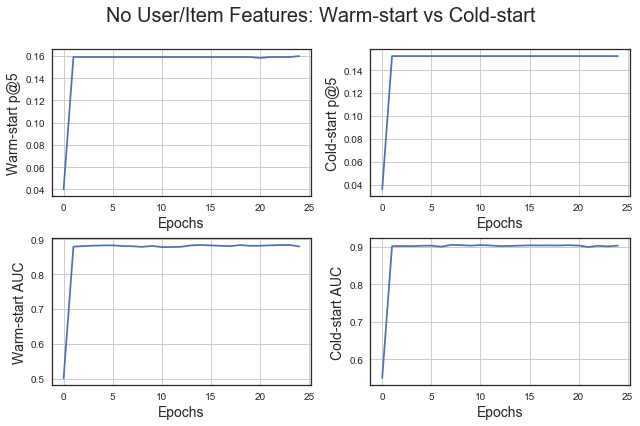

In [602]:
# Try tracking p@5 at each epoch
warm_patks = []
cold_patks = []
warm_aucs = []
cold_aucs = []

K = 5

# Initiate model
opt_model_no_features = LightFM(loss='warp',
                   random_state=2016,
                   learning_rate=opt_lr_no_features,
                   no_components=opt_no_components_no_features,
                   user_alpha=opt_user_alpha_no_features,
                   item_alpha=opt_item_alpha_no_features)

# Pre-training evaluation
opt_model_no_features.fit_partial(train, epochs=0)
warm_patk = lightfm.evaluation.precision_at_k(opt_model_no_features, test_warm,
                                         k=K).mean()
cold_patk = lightfm.evaluation.precision_at_k(opt_model_no_features, test_cold,
                                         k=K).mean()
warm_auc = lightfm.evaluation.auc_score(opt_model_no_features, test_warm
                                         ).mean()
cold_auc = lightfm.evaluation.auc_score(opt_model_no_features, test_cold
                                         ).mean()

warm_patks.append(warm_patk)
cold_patks.append(cold_patk)
warm_aucs.append(warm_auc)
cold_aucs.append(cold_auc)

# Loop over optimal num. epochs
for i in range(opt_epochs_no_features):
    # run through 1 epoch
    opt_model_no_features.fit_partial(train)
    
    # Evaluate
    warm_patk = lightfm.evaluation.precision_at_k(opt_model_no_features, test_warm,
                                             k=K).mean()
    cold_patk = lightfm.evaluation.precision_at_k(opt_model_no_features, test_cold,
                                             k=K).mean()
    warm_auc = lightfm.evaluation.auc_score(opt_model_no_features, test_warm
                                             ).mean()
    cold_auc = lightfm.evaluation.auc_score(opt_model_no_features, test_cold
                                             ).mean()

    warm_patks.append(warm_patk)
    cold_patks.append(cold_patk)
    warm_aucs.append(warm_auc)
    cold_aucs.append(cold_auc)

print "Final warm-start test p@{}: ".format(K) + str(warm_patks[-1])
print "Final cold-start test p@{}: ".format(K) + str(cold_patks[-1])
print "Final warm-start test AUC: " + str(warm_aucs[-1])
print "Final cold-start test AUC: " + str(cold_aucs[-1])


### Plot the result ###

plt.suptitle('No User/Item Features: Warm-start vs Cold-start', fontsize=20)

# Train plot
plt.subplot(2, 2, 1)
plt.plot(warm_patks)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Warm-start p@{}'.format(K), fontsize=14)
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(cold_patks)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Cold-start p@{}'.format(K), fontsize=14)
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(warm_aucs)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Warm-start AUC', fontsize=14)
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(cold_aucs)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Cold-start AUC'.format(K), fontsize=14)
plt.grid(True)

plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()

In this case (with no features), cold start recommendations simply recommend the most popular items (based on item biases). We can see that icp_features outperform no_features in the cold-start problem, meaning that **the model is outperorming a simple popularity-based recommender**. Our icp_features model also outperforms the no_features model in the warm-start problem, meaning that the **features are indeed adding meaningful information** to the original collaborative filtering info. Good stuff!

For the sake of being thorough, let's run this warm-start vs. cold-start test on the remaining models as well: CDN-features-only, and all-features.

In [704]:
# Evaluate optimal CDN-features-only model (already trained from earlier)
cdn_patk_warm = lightfm.evaluation.precision_at_k(opt_model_cdn, test_warm,
                                             item_features=cdn_features,
                                             train_interactions=None,
                                             k=5).mean()
cdn_patk_cold = lightfm.evaluation.precision_at_k(opt_model_cdn, test_cold,
                                             item_features=cdn_features,
                                             train_interactions=None,
                                             k=5).mean()
cdn_auc_warm = lightfm.evaluation.auc_score(opt_model_cdn, test_warm,
                                             item_features=cdn_features,
                                             train_interactions=None
                                             ).mean()
cdn_auc_cold = lightfm.evaluation.auc_score(opt_model_cdn, test_cold,
                                             item_features=cdn_features,
                                             train_interactions=None
                                             ).mean()
print "CDN Features Only Warm p@5: " + str(cdn_patk_warm)
print "CDN Features Only Cold p@5: " + str(cdn_patk_cold)
print "CDN Features Only Warm AUC: " + str(cdn_auc_warm)
print "CDN Features Only Cold AUC: " + str(cdn_auc_cold)

CDN Features Only Warm p@5: 0.159833
CDN Features Only Cold p@5: 0.152239
CDN Features Only Warm AUC: 0.88106
CDN Features Only Cold AUC: 0.903208


In [718]:
# Evaluate optimal all-features model (already trained from earlier)
all_patk_warm = lightfm.evaluation.precision_at_k(opt_model_all, test_warm,
                                             user_features=icp_features,
                                             item_features=cdn_features,
                                             train_interactions=None,
                                             k=5).mean()
all_patk_cold = lightfm.evaluation.precision_at_k(opt_model_all, test_cold,
                                             user_features=icp_features,
                                             item_features=cdn_features,
                                             train_interactions=None,
                                             k=5).mean()
all_auc_warm = lightfm.evaluation.auc_score(opt_model_all, test_warm,
                                             user_features=icp_features,
                                             item_features=cdn_features,
                                             train_interactions=None
                                             ).mean()
all_auc_cold = lightfm.evaluation.auc_score(opt_model_all, test_cold,
                                             user_features=icp_features,
                                             item_features=cdn_features,
                                             train_interactions=None
                                             ).mean()
print "All Features Warm p@5: " + str(all_patk_warm)
print "All Features Cold p@5: " + str(all_patk_cold)
print "All Features Warm AUC: " + str(all_auc_warm)
print "All Features Cold AUC: " + str(all_auc_cold)

All Features Warm p@5: 0.156485
All Features Cold p@5: 0.159701
All Features Warm AUC: 0.882735
All Features Cold AUC: 0.905957


Not entirely sure why the all-features model has higher scores in the cold-start case than in the warm-start case... Perhaps it's just random chance? More data would certainly be helpful to try to figure this out.

## Similarity Testing
------
To make sure our model's predictions make intuitive sense, we can try prodding our model to see what it ICPs/websites it thinks are similar. If these similarities make sense, then the model is probably doing something correctly.

In [579]:
# Use model.user_embeddings
# sklearn cosine similarity
from sklearn.metrics.pairwise import cosine_similarity

In [624]:
icp_biases, icp_embeddings = opt_model_icp.get_user_representations(icp_features)

In [625]:
# Cosine similarity matrix (row: icp_index, col: icp index)
icp_similarity_matrix = cosine_similarity(icp_embeddings)

In [626]:
# Need to mean center?
# Look up "adjusted cosine similarity": mean-center each individual user vector
# https://grouplens.org/blog/similarity-functions-for-user-user-collaborative-filtering/

# Seems like they use this for CF... probably don't need it to just compare ICPs here

In [645]:
# Input: ICP name, K (how many similar ICPs to find)
# Output: Sorted list of top (ICP, cosine similarity) tuples
def k_similar_icps(icp_name, K):
    similar_icps = []
    icp_uidx = icp_to_uidx[icp_name]
    
    # Compute cosine similarities
    similarity_vec = icp_similarity_matrix[icp_uidx]
    
    # K highest cosine similarities
    k_most_similar = np.argsort(similarity_vec)[::-1][1:K+1] # 0th element = ICP itself
    
    # Convert to ICP name
    for icp_id in k_most_similar:
        similar_icps.append((uidx_to_icp[icp_id], similarity_vec[icp_id]))
        
    return similar_icps

In [642]:
# Text heavy
k_similar_icps('www.qq.com', 5)

[('www.163.com', 0.99986196),
 ('www.xilu.com', 0.99931043),
 ('www.55bbs.com', 0.99899864),
 ('5173tuan.com', 0.99687028),
 ('www.jumei.com', 0.99671626)]

Kind of boring, but mostly text-based sites that look sort of like old news websites. Seems to make sense.

In [675]:
k_similar_icps('www.oppo.com', 5)

[('www.chinahighway.com', 0.99995166),
 ('www.bmw.com.cn', 0.99994117),
 ('www.vogue.com.cn', 0.99991596),
 ('www.nipic.com', 0.99986744),
 ('www.feel-bar.com', 0.99982882)]

Not sure why chinahighway.com showed up... chinahighway.com seems like it should fit in the text-based category. Alas, Oppo, BMW, and Vogue all seem really similar, so not all is lost. Similarly structured landing pages: huge scrolling images that pop out immediately.

In [644]:
# Online marketplace
k_similar_icps('www.amazon.cn', 5)

[('www.egou.com', 0.99980402),
 ('www.gome.com.cn', 0.9998014),
 ('www.meilishuo.com', 0.99961048),
 ('www.zhubajie.com', 0.99956733),
 ('www.shangpin.com', 0.99926943)]

Amazon and Egou seem really similar. Both are online marketplaces with similar site layouts.

In [670]:
# Government/public affairs
k_similar_icps('www.gov.cn', 5)

[('www.chengtu.com', 0.99468189),
 ('www.ffpic.com', 0.993563),
 ('www.williamlong.info', 0.993527),
 ('www.qgyyzs.net', 0.99348938),
 ('www.haocodes.com', 0.99336886)]

Not sure if it's official or not, but chengtu.com seems kind of like a public affairs page for Chengdu. Makes sense that it'd be grouped in with gov.cn. The similarities honestly aren't as apparent for the others, but perhaps there's more going on that we can't really see just from the landing pages.

In [665]:
# Input: ICP name
# Output: List of interacted CDN codes interacted
def cdns_used(icp_name):
    cdn_codes = []
    icp_uidx = icp_to_uidx[icp_name]
    
    # extract ICP's row from interactions matrix
    icp_interactions = interactions[icp_uidx].toarray()[0]
    
    # List of iidxs where "interacted" = true
    used_cdn_ids = [iidx for iidx, interaction in enumerate(icp_interactions) if interaction == 1]
    for cdn_id in used_cdn_ids:
        cdn_codes.append(iidx_to_cdn[cdn_id])
    
    return sorted(cdn_codes)

In [666]:
# See if similar sites have used same CDNs
print cdns_used('www.qq.com')
print cdns_used('www.163.com')

['001', '002', '003', '005', '101']
['001', '002', '004', '005']


In [671]:
### Just for the hell of it ### 

# Inspiration: https://medium.com/@timsears/the-opposite-of-hitler-5eb570346020
# https://www.distilled.net/resources/a-beginners-guide-to-word2vec-aka-whats-the-opposite-of-canada/

# Input: ICP name, K (how many similar ICPs to find)
# Output: Sorted list of worst (ICP, cosine similarity) tuples
def least_similar_icps(icp_name, K):
    least_similar_icps = []
    icp_uidx = icp_to_uidx[icp_name]
    
    # Compute cosine similarities
    similarity_vec = icp_similarity_matrix[icp_uidx]
    
    # K lowest cosine similarities
    k_least_similar = np.argsort(similarity_vec)[0:K]
    
    # Convert to ICP name
    for icp_id in k_least_similar:
        least_similar_icps.append((uidx_to_icp[icp_id], similarity_vec[icp_id]))
        
    return least_similar_icps

In [672]:
least_similar_icps('www.amazon.cn', 5)

[('www.gov.cn', 0.69258672),
 ('www.ucbug.com', 0.72667307),
 ('www.91danji.com', 0.72751313),
 ('www.chengtu.com', 0.73390758),
 ('www.ctw.cn', 0.73515195)]

Amazon vs. the Chinese Government? I guess that sort of makes sense...

If only we had more US-based sites in the dataset. Anyway, it seems like the recommender system is performing decently well, considering that there are so many more factors involved in ICP similarity in addition to just the visual aspect of the webpages.

It would definitely be interesting to see something like this recommender system applied to US-based content providers as well. If I had more time, I would also like to do some more feature-engineering on both the ICP and CDN features to see what features actually allow the model to improve its recommendations. As a proof-of-concept, though, this initial CDN recommender system project seems like a pretty good first step!